In [60]:
import numpy as np
from matplotlib import pyplot as plt
import time


In [61]:
def square(patterns):
    x = np.sin(patterns)
    return np.where(x>=0,1,-1)

def generate_data(is_sin):
    training_patterns = np.arange(0,2*np.pi,0.1)
    
    #test_patterns = np.arange(0,2*np.pi,0.05)
    test_patterns = np.arange(0.05,2*np.pi,0.1)

    if is_sin:
        training_targets = np.sin(2*training_patterns)
        test_targets = np.sin(2*test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets , test_patterns, test_targets
    
    else:
        training_targets = square(training_patterns)
        test_targets = square(test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets, test_patterns, test_targets


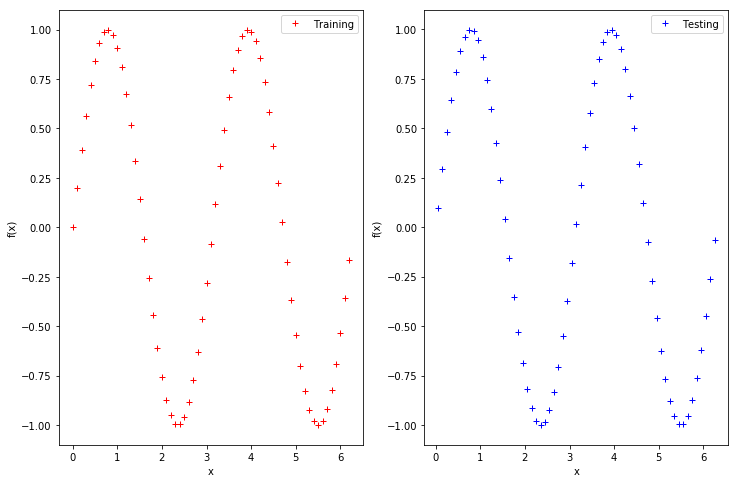

In [62]:
training_patterns, training_targets, test_patterns, test_targets = generate_data(1)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(training_patterns,training_targets, 'r+',label='Training')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()

ax2.plot(test_patterns,test_targets,'b+',label='Testing')
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.legend()

plt.show()

In [63]:
def evenly_spaced_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = i*2*np.pi/n
    return mu_s

def random_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = (2*np.random.random_sample()*np.pi)
    return mu_s

def calculate_NMAE(f_hat,f):
    return np.mean(np.abs(f_hat-f))

def calculate_mse(f_hat,f):
    return np.mean((f_hat-f)**2)

def gaussian(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))

def get_phi(x_s, mu_s,sigma):
    phi_s = np.zeros((x_s.shape[0],mu_s.shape[0]))
    for i, mu in enumerate(mu_s):
        for j, x in enumerate(x_s):
            phi_s[j,i]=gaussian(mu,x,sigma)
    return phi_s

def get_phi_seq(x_s,mu_s, sigma):
    #print(x_s.shape)
    phi_s = np.zeros((mu_s.shape[1],1))
    #print(phi_s.shape)
    for i, mu in enumerate(mu_s.T):
        #print(i)
        phi_s=gaussian(mu,x_s,sigma)
    return phi_s

def train_network_batch(x_s,f,mu_s,sigma):
    phi_s = get_phi(x_s,mu_s,sigma)
    
    w = np.matmul(np.matmul(phi_s.T,f),np.linalg.inv(np.matmul(phi_s.T,phi_s)))
    f_hat = np.sum(np.multiply(phi_s,w),axis=1)
    
    nmae = calculate_NMAE(f_hat,f)
    return w, nmae

def train_network_delta_rule(x_s,f,mu_s,sigma,eta, epochs):
    learning_error_list= np.zeros(epochs)
    W=np.random.randn(mu_s.shape[0],1)
    
    for i in range(epochs):
        e_list=[]
        x = np.zeros(1)
        for k in range(np.shape(x_s)[0]):
            x[0] = x_s[k]
            phi = get_phi_seq(x,mu_s,sigma)
            phi = phi.reshape(1,-1)
            e = f[k] - phi.dot(W)
            error = np.float(0.5*(e**2))
            error2 = np.abs(e)
            e_list.append(error2)
            W = W + eta*e*phi.reshape(mu_s.shape[0],1)

        learning_error = np.mean(e_list)
        learning_error_list[i] = learning_error
    
    return W,learning_error_list
    
def predict(x_s,mu_s,sigma,w):
    phi_s = get_phi(x_s,mu_s,sigma)
    
    w = w.reshape((w.shape[0],1))
    f_hat = np.sum(np.dot(phi_s,w),axis=1)
    return f_hat

def predict_seq(x_s,mu_s,sigma,w):
    f_hats = np.zeros(x_s.shape[0])
    x = np.zeros(1)
    for k in range(np.shape(x_s)[0]):
        x[0] = x_s[k]
        phi_s = get_phi_seq(x,mu_s,sigma)
    
        w = w.reshape((w.shape[0],1))
        f_hat = np.sum(np.dot(phi_s,w))
        f_hats[k] = f_hat
    return f_hats

### 3.1 Batch mode training using least squares - supervised learning of network weights

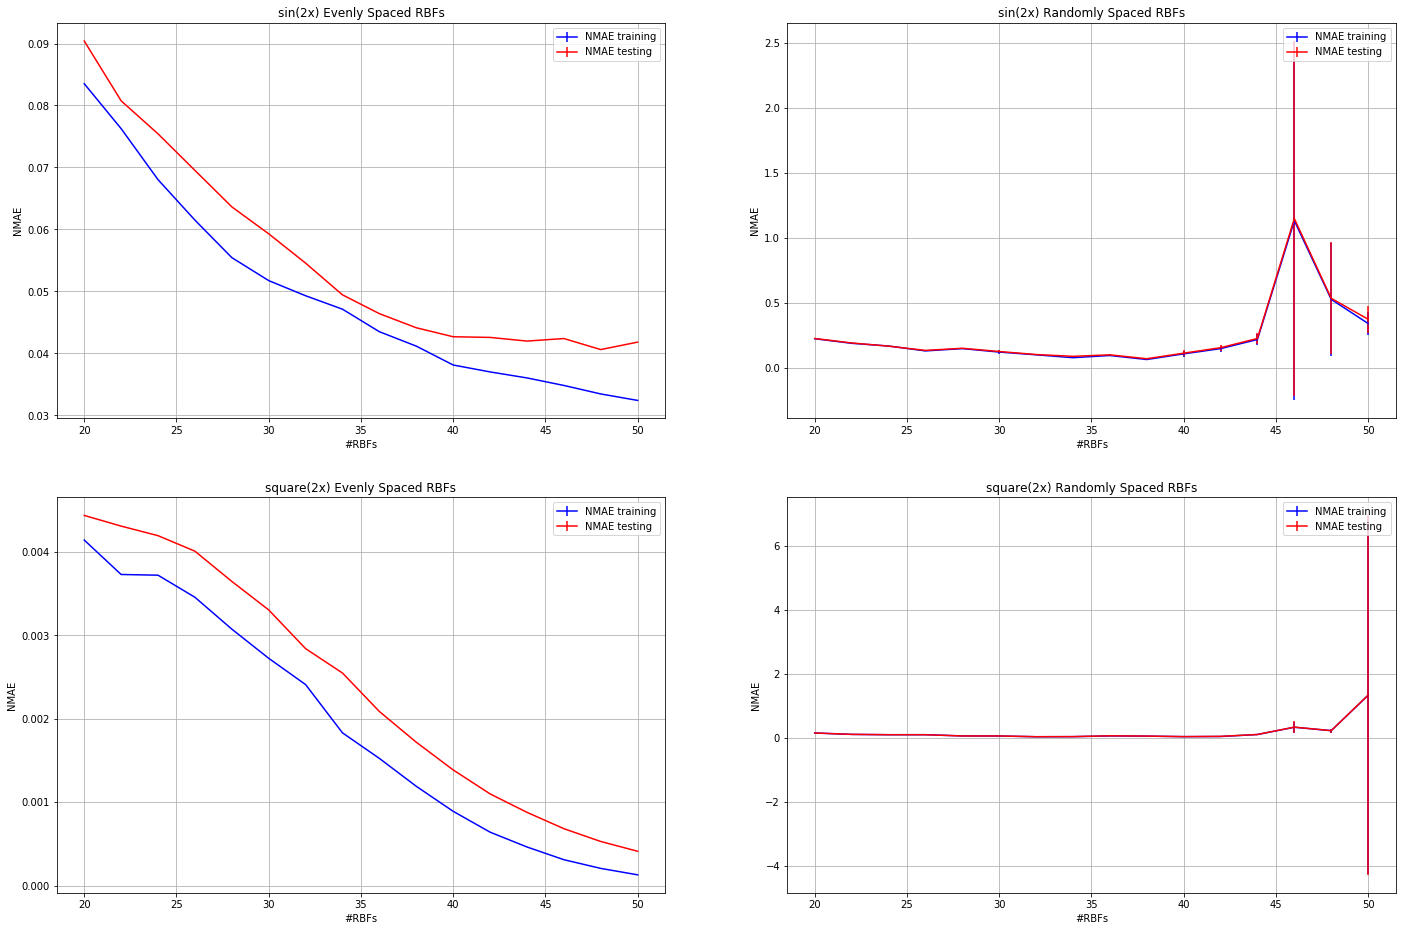

In [64]:
sigma = 0.2
num_of_rbf = [20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
repeat = 10

data_testing_es = np.zeros((repeat,len(num_of_rbf),2))
data_testing_r = np.zeros((repeat,len(num_of_rbf),2))
data_training_es = np.zeros((repeat,len(num_of_rbf),2))
data_training_r = np.zeros((repeat,len(num_of_rbf),2))

for k in range(2):
    training_patterns, training_targets, test_patterns, test_targets = generate_data(k)
    for j in range(repeat):
        for i,n in enumerate(num_of_rbf):
            mu_es = evenly_spaced_rbf(n)
            mu_r = random_rbf(n)

            w_es,nmae_es = train_network_batch(training_patterns, training_targets,mu_es,sigma)
            w_r,nmae_r = train_network_batch(training_patterns, training_targets,mu_r,sigma)

            f_hat_es = predict(test_patterns,mu_es,sigma,w_es)
            f_hat_r = predict(test_patterns,mu_r,sigma,w_r)

            data_testing_es[j,i,k] = calculate_NMAE(f_hat_es,test_targets)
            data_testing_r[j,i,k] = calculate_NMAE(f_hat_r,test_targets)
            data_training_es[j,i,k] = nmae_es
            data_training_r[j,i,k] = nmae_r
    
fig = plt.figure(figsize=(24,16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.errorbar(num_of_rbf,np.mean(data_training_es[:,:,0],axis=0),yerr=np.var(data_training_es[:,:,0],axis=0),fmt='b',label='NMAE training')
ax1.errorbar(num_of_rbf,np.mean(data_testing_es[:,:,0],axis=0),yerr=np.var(data_testing_es[:,:,0],axis=0),fmt='r',label='NMAE testing')
ax1.set_title('sin(2x) Evenly Spaced RBFs')
ax1.set_xlabel('#RBFs')
ax1.set_ylabel('NMAE')
ax1.legend()
ax1.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax2.errorbar(num_of_rbf,np.mean(data_training_r[:,:,0],axis=0),yerr=np.var(data_training_r[:,:,0],axis=0),fmt='b',label='NMAE training')
ax2.errorbar(num_of_rbf,np.mean(data_testing_r[:,:,0],axis=0),yerr=np.var(data_testing_r[:,:,0],axis=0),fmt='r',label='NMAE testing')
ax2.set_title('sin(2x) Randomly Spaced RBFs')
ax2.set_xlabel('#RBFs')
ax2.set_ylabel('NMAE')
ax2.legend()
ax2.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax3.errorbar(num_of_rbf,np.mean(data_training_es[:,:,1],axis=0),yerr=np.var(data_training_es[:,:,1],axis=0),fmt='b',label='NMAE training')
ax3.errorbar(num_of_rbf,np.mean(data_testing_es[:,:,1],axis=0),yerr=np.var(data_testing_es[:,:,1],axis=0),fmt='r',label='NMAE testing')
ax3.set_title('square(2x) Evenly Spaced RBFs')
ax3.set_xlabel('#RBFs')
ax3.set_ylabel('NMAE')
ax3.legend()
ax3.grid(True)
#ax3.set_xlim([2,12])
#ax3.set_ylim([0,0.8])

ax4.errorbar(num_of_rbf,np.mean(data_training_r[:,:,1],axis=0),yerr=np.var(data_training_r[:,:,1],axis=0),fmt='b',label='NMAE training')
ax4.errorbar(num_of_rbf,np.mean(data_testing_r[:,:,1],axis=0),yerr=np.var(data_testing_r[:,:,1],axis=0),fmt='r',label='NMAE testing')
ax4.set_title('square(2x) Randomly Spaced RBFs')
ax4.set_xlabel('#RBFs')
ax4.set_ylabel('NMAE')
ax4.legend()
ax4.grid(True)
#ax4.set_xlim([2,12])
#ax4.set_ylim([0,0.8])

plt.show()



### 3.2 Regression with noise

#### Checking NMAE for delta rule learning with varying learning rate

In [65]:
repeat = 10
eta = [1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4]
epochs = 20
sigma = 1
n = 10

data_training_es_seq = np.zeros((repeat,len(eta)))
data_training_r_seq = np.zeros((repeat,len(eta)))
data_testing_es_seq = np.zeros((repeat,len(eta)))
data_testing_r_seq = np.zeros((repeat,len(eta)))



for times in range(repeat):
    training_patterns, training_targets, test_patterns, test_targets = generate_data(1)
    mu_es = evenly_spaced_rbf(n)
    mu_r = random_rbf(n)
    
    for it,rate in enumerate(eta):
        w_seq_es,nmae_seq_es = train_network_delta_rule(training_patterns, training_targets,mu_es,sigma,rate,epochs)
        w_seq_r,nmae_seq_r = train_network_delta_rule(training_patterns, training_targets,mu_r,sigma,rate,epochs)
        
        f_hat_seq_es = []
        f_hat_seq_r = []
        
        #for elem in range(test_patterns.shape[0]):
        tmp_es = predict_seq(test_patterns,mu_es,sigma,w_seq_es)
        tmp_r = predict_seq(test_patterns,mu_r,sigma,w_seq_r)
        f_hat_seq_es.append(tmp_es)
        f_hat_seq_r.append(tmp_r)
            
        data_testing_es_seq[times,it] = calculate_NMAE(f_hat_seq_es,test_targets) 
        data_testing_r_seq[times,it] = calculate_NMAE(f_hat_seq_r,test_targets) 
        data_training_es_seq[times,it] = nmae_seq_es[-1]       
        data_training_r_seq[times,it] = nmae_seq_r[-1]
        
    

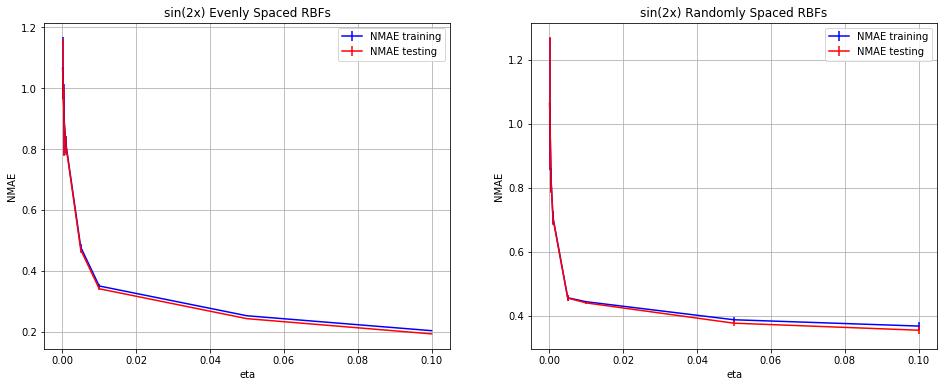

In [66]:
    
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


ax1.errorbar(eta,np.mean(data_training_es_seq,axis=0),yerr=np.around(np.var(data_training_es_seq,axis=0),4),fmt='b',label='NMAE training')
ax1.errorbar(eta,np.mean(data_testing_es_seq,axis=0),yerr=np.around(np.var(data_testing_es_seq,axis=0),4),fmt='r',label='NMAE testing')
ax1.set_title('sin(2x) Evenly Spaced RBFs')
ax1.set_xlabel('eta')
ax1.set_ylabel('NMAE')
ax1.legend()
ax1.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax2.errorbar(eta,np.mean(data_training_r_seq,axis=0),yerr=np.around(np.var(data_training_r_seq,axis=0),4),fmt='b',label='NMAE training')
ax2.errorbar(eta,np.mean(data_testing_r_seq,axis=0),yerr=np.around(np.var(data_testing_r_seq,axis=0),4),fmt='r',label='NMAE testing')
ax2.set_title('sin(2x) Randomly Spaced RBFs')
ax2.set_xlabel('eta')
ax2.set_ylabel('NMAE')
ax2.legend()
ax2.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


plt.show()



#### NMAE for batch mode and sequential mode with varying sigma and number of RBFs

In [67]:
addNoise = True
eta = 1e-1
epochs = 10
repeat  = 10
sigmas = [0.1,0.25,0.5,0.75,1,1.25,1.5]
num_of_rbf = [2,4,6,8,10,12]

data_testing_es = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_testing_r = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_training_es = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_training_r = np.zeros((len(num_of_rbf),len(sigmas),repeat))

data_training_es_seq = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_training_r_seq = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_testing_es_seq = np.zeros((len(num_of_rbf),len(sigmas),repeat))
data_testing_r_seq = np.zeros((len(num_of_rbf),len(sigmas),repeat))

    
#data  j x k x i
#  rbfs x sigmas x validation
for i in range(repeat):
    training_patterns, training_targets, test_patterns, test_targets = generate_data(1)
    
    if addNoise:
        noise=np.random.randn(training_patterns.shape[0])*0.1
        noise_test=np.random.randn(test_patterns.shape[0])*0.1
        training_patterns = training_patterns+noise
        test_patterns = test_patterns+noise_test
    
    for j,n in enumerate(num_of_rbf):
        mu_es = evenly_spaced_rbf(n)
        mu_r = random_rbf(n)
        for k,sigma in enumerate(sigmas): 
            w_es,nmae_es = train_network_batch(training_patterns, training_targets,mu_es,sigma)
            w_r,nmae_r = train_network_batch(training_patterns, training_targets,mu_r,sigma)
            
            w_seq_es,nmae_seq_es = train_network_delta_rule(training_patterns, training_targets,mu_es,sigma,eta,epochs)
            w_seq_r,nmae_seq_r = train_network_delta_rule(training_patterns, training_targets,mu_r,sigma,eta,epochs)
            #print(n)
            #print(sigma)
            #print(nmae_es)
            f_hat_es = predict(test_patterns,mu_es,sigma,w_es)
            f_hat_r = predict(test_patterns,mu_r,sigma,w_r)
            
            f_hat_seq_es = []
            f_hat_seq_r = []
            #for elem in range(test_patterns.shape[0]):
            tmp_es = predict_seq(test_patterns,mu_es,sigma,w_seq_es)
            tmp_r = predict_seq(test_patterns,mu_r,sigma,w_seq_r)
            f_hat_seq_es.append(tmp_es)
            f_hat_seq_r.append(tmp_r)
                
            data_testing_es_seq[j,k,i] = calculate_NMAE(f_hat_seq_es,test_targets) 
            data_testing_r_seq[j,k,i] = calculate_NMAE(f_hat_seq_r,test_targets) 
            data_testing_es[j,k,i] = calculate_NMAE(f_hat_es,test_targets)
            data_testing_r[j,k,i] = calculate_NMAE(f_hat_r,test_targets)
            
            data_training_es_seq[j,k,i] = nmae_seq_es[-1]       #-1 to get the nmae for the last epoch
            data_training_r_seq[j,k,i] = nmae_seq_r[-1]
            
            data_training_es[j,k,i] = nmae_es
            data_training_r[j,k,i] = nmae_r



#### Plot for evenly spaced RBFs

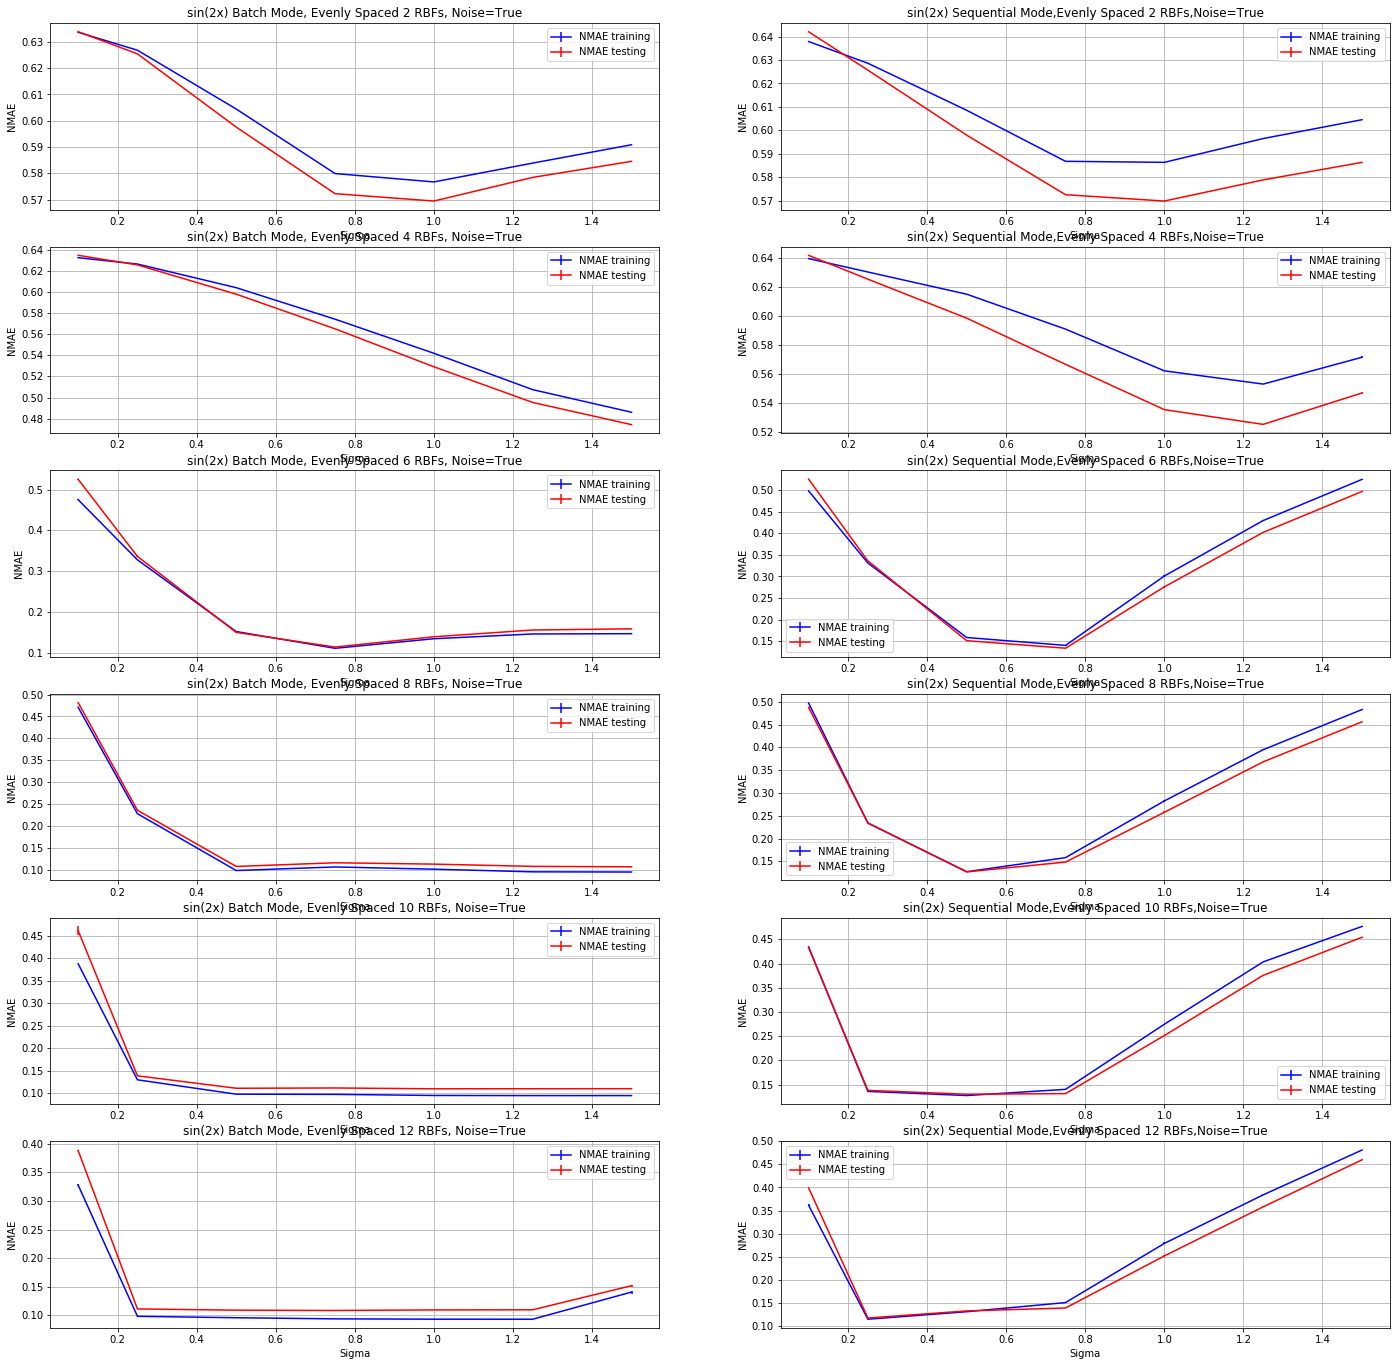

In [68]:
fig1 = plt.figure(figsize=(24,24))

ax1 = fig1.add_subplot(6,2,1)
ax2 = fig1.add_subplot(6,2,2)
ax3 = fig1.add_subplot(6,2,3)
ax4 = fig1.add_subplot(6,2,4)
ax5 = fig1.add_subplot(6,2,5)
ax6 = fig1.add_subplot(6,2,6)
ax7 = fig1.add_subplot(6,2,7)
ax8 = fig1.add_subplot(6,2,8)
ax9 = fig1.add_subplot(6,2,9)
ax10 = fig1.add_subplot(6,2,10)
ax11 = fig1.add_subplot(6,2,11)
ax12 = fig1.add_subplot(6,2,12)


#print(np.mean(data_training_es[3,:,:],axis=1))
#print(np.var(data_training_es[3,:,:],axis=1))


ax1.errorbar(sigmas,np.mean(data_training_es[0,:,:],axis=1),yerr=np.var(data_training_es[0,:,:],axis=1),fmt='b',label='NMAE training')
ax1.errorbar(sigmas,np.mean(data_testing_es[0,:,:],axis=1),yerr=np.var(data_testing_es[0,:,:],axis=1),fmt='r',label='NMAE testing')
ax1.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[0])+' RBFs, Noise=True')
ax1.set_xlabel('Sigma')
ax1.set_ylabel('NMAE')
ax1.legend()
ax1.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax2.errorbar(sigmas,np.mean(data_training_es_seq[0,:,:],axis=1),yerr=np.var(data_training_es_seq[0,:,:],axis=1),fmt='b',label='NMAE training')
ax2.errorbar(sigmas,np.mean(data_testing_es_seq[0,:,:],axis=1),yerr=np.var(data_testing_es_seq[0,:,:],axis=1),fmt='r',label='NMAE testing')
ax2.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[0])+' RBFs,Noise=True')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('NMAE')
ax2.legend()
ax2.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax3.errorbar(sigmas,np.mean(data_training_es[1,:,:],axis=1),yerr=np.var(data_training_es[1,:,:],axis=1),fmt='b',label='NMAE training')
ax3.errorbar(sigmas,np.mean(data_testing_es[1,:,:],axis=1),yerr=np.var(data_testing_es[1,:,:],axis=1),fmt='r',label='NMAE testing')
ax3.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[1])+' RBFs, Noise=True')
ax3.set_xlabel('Sigma')
ax3.set_ylabel('NMAE')
ax3.legend()
ax3.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax4.errorbar(sigmas,np.mean(data_training_es_seq[1,:,:],axis=1),yerr=np.var(data_training_es_seq[1,:,:],axis=1),fmt='b',label='NMAE training')
ax4.errorbar(sigmas,np.mean(data_testing_es_seq[1,:,:],axis=1),yerr=np.var(data_testing_es_seq[1,:,:],axis=1),fmt='r',label='NMAE testing')
ax4.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[1])+' RBFs,Noise=True')
ax4.set_xlabel('Sigma')
ax4.set_ylabel('NMAE')
ax4.legend()
ax4.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax5.errorbar(sigmas,np.mean(data_training_es[2,:,:],axis=1),yerr=np.var(data_training_es[2,:,:],axis=1),fmt='b',label='NMAE training')
ax5.errorbar(sigmas,np.mean(data_testing_es[2,:,:],axis=1),yerr=np.var(data_testing_es[2,:,:],axis=1),fmt='r',label='NMAE testing')
ax5.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[2])+' RBFs, Noise=True')
ax5.set_xlabel('Sigma')
ax5.set_ylabel('NMAE')
ax5.legend()
ax5.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax6.errorbar(sigmas,np.mean(data_training_es_seq[2,:,:],axis=1),yerr=np.var(data_training_es_seq[2,:,:],axis=1),fmt='b',label='NMAE training')
ax6.errorbar(sigmas,np.mean(data_testing_es_seq[2,:,:],axis=1),yerr=np.var(data_testing_es_seq[2,:,:],axis=1),fmt='r',label='NMAE testing')
ax6.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[2])+' RBFs,Noise=True')
ax6.set_xlabel('Sigma')
ax6.set_ylabel('NMAE')
ax6.legend()
ax6.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])


ax7.errorbar(sigmas,np.mean(data_training_es[3,:,:],axis=1),yerr=np.around(np.var(data_training_es[3,:,:],axis=1),2),fmt='b',label='NMAE training')
ax7.errorbar(sigmas,np.mean(data_testing_es[3,:,:],axis=1),yerr=np.around(np.var(data_testing_es[3,:,:],axis=1),2),fmt='r',label='NMAE testing')
ax7.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[3])+' RBFs, Noise=True')
ax7.set_xlabel('Sigma')
ax7.set_ylabel('NMAE')
ax7.legend()
ax7.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax8.errorbar(sigmas,np.mean(data_training_es_seq[3,:,:],axis=1),yerr=np.var(data_training_es_seq[3,:,:],axis=1),fmt='b',label='NMAE training')
ax8.errorbar(sigmas,np.mean(data_testing_es_seq[3,:,:],axis=1),yerr=np.var(data_testing_es_seq[3,:,:],axis=1),fmt='r',label='NMAE testing')
ax8.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[3])+' RBFs,Noise=True')
ax8.set_xlabel('Sigma')
ax8.set_ylabel('NMAE')
ax8.legend()
ax8.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax9.errorbar(sigmas,np.mean(data_training_es[4,:,:],axis=1),yerr=np.var(data_training_es[4,:,:],axis=1),fmt='b',label='NMAE training')
ax9.errorbar(sigmas,np.mean(data_testing_es[4,:,:],axis=1),yerr=np.var(data_testing_es[4,:,:],axis=1),fmt='r',label='NMAE testing')
ax9.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[4])+' RBFs, Noise=True')
ax9.set_xlabel('Sigma')
ax9.set_ylabel('NMAE')
ax9.legend()
ax9.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax10.errorbar(sigmas,np.mean(data_training_es_seq[4,:,:],axis=1),yerr=np.var(data_training_es_seq[4,:,:],axis=1),fmt='b',label='NMAE training')
ax10.errorbar(sigmas,np.mean(data_testing_es_seq[4,:,:],axis=1),yerr=np.var(data_testing_es_seq[4,:,:],axis=1),fmt='r',label='NMAE testing')
ax10.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[4])+' RBFs,Noise=True')
ax10.set_xlabel('Sigma')
ax10.set_ylabel('NMAE')
ax10.legend()
ax10.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax11.errorbar(sigmas,np.mean(data_training_es[5,:,:],axis=1),yerr=np.var(data_training_es[5,:,:],axis=1),fmt='b',label='NMAE training')
ax11.errorbar(sigmas,np.mean(data_testing_es[5,:,:],axis=1),yerr=np.var(data_testing_es[5,:,:],axis=1),fmt='r',label='NMAE testing')
ax11.set_title('sin(2x) Batch Mode, Evenly Spaced '+str(num_of_rbf[5])+' RBFs, Noise=True')
ax11.set_xlabel('Sigma')
ax11.set_ylabel('NMAE')
ax11.legend()
ax11.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax12.errorbar(sigmas,np.mean(data_training_es_seq[5,:,:],axis=1),yerr=np.var(data_training_es_seq[5,:,:],axis=1),fmt='b',label='NMAE training')
ax12.errorbar(sigmas,np.mean(data_testing_es_seq[5,:,:],axis=1),yerr=np.var(data_testing_es_seq[5,:,:],axis=1),fmt='r',label='NMAE testing')
ax12.set_title('sin(2x) Sequential Mode,Evenly Spaced '+str(num_of_rbf[5])+' RBFs,Noise=True')
ax12.set_xlabel('Sigma')
ax12.set_ylabel('NMAE')
ax12.legend()
ax12.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])


plt.show()


Med fler noder så får vi ett mindre fel med mindre varians. Det makear sense eftersom vi då har fler noder och de behöver då inte täcka upp lika mycket yta som om det var färre noder. Jämför med när vi har färre noder då vi får lägst error med ett lite större sigma.

#### Plot for randomly spaced RBFs

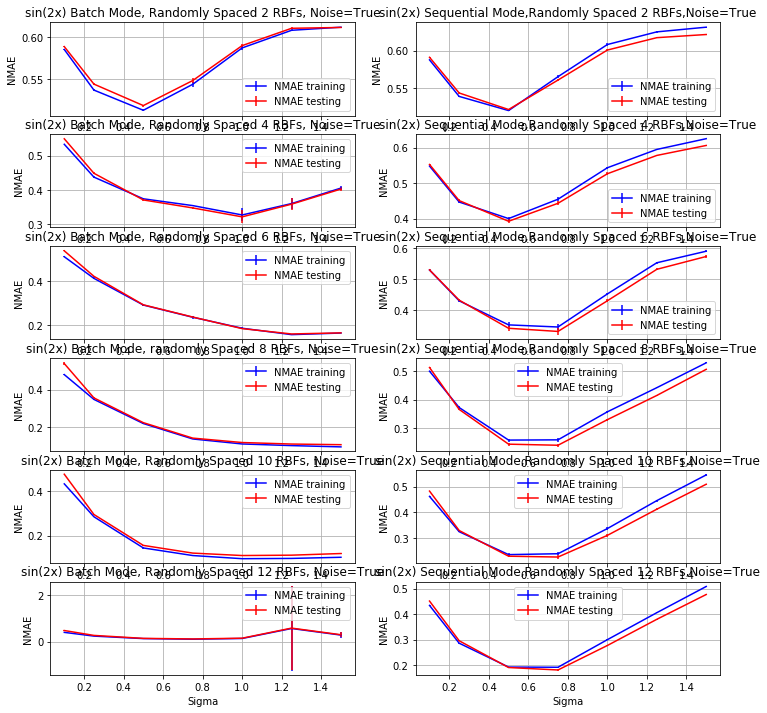

In [69]:
fig2 = plt.figure(figsize=(12,12))


ax1 = fig2.add_subplot(6,2,1)
ax2 = fig2.add_subplot(6,2,2)
ax3 = fig2.add_subplot(6,2,3)
ax4 = fig2.add_subplot(6,2,4)
ax5 = fig2.add_subplot(6,2,5)
ax6 = fig2.add_subplot(6,2,6)
ax7 = fig2.add_subplot(6,2,7)
ax8 = fig2.add_subplot(6,2,8)
ax9 = fig2.add_subplot(6,2,9)
ax10 = fig2.add_subplot(6,2,10)
ax11 = fig2.add_subplot(6,2,11)
ax12 = fig2.add_subplot(6,2,12)



ax1.errorbar(sigmas,np.mean(data_training_r[0,:,:],axis=1),yerr=np.var(data_training_r[0,:,:],axis=1),fmt='b',label='NMAE training')
ax1.errorbar(sigmas,np.mean(data_testing_r[0,:,:],axis=1),yerr=np.var(data_testing_r[0,:,:],axis=1),fmt='r',label='NMAE testing')
ax1.set_title('sin(2x) Batch Mode, Randomly Spaced '+str(num_of_rbf[0])+' RBFs, Noise=True')
ax1.set_xlabel('Sigma')
ax1.set_ylabel('NMAE')
ax1.legend()
ax1.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax2.errorbar(sigmas,np.mean(data_training_r_seq[0,:,:],axis=1),yerr=np.var(data_training_r_seq[0,:,:],axis=1),fmt='b',label='NMAE training')
ax2.errorbar(sigmas,np.mean(data_testing_r_seq[0,:,:],axis=1),yerr=np.var(data_testing_r_seq[0,:,:],axis=1),fmt='r',label='NMAE testing')
ax2.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[0])+' RBFs,Noise=True')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('NMAE')
ax2.legend()
ax2.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax3.errorbar(sigmas,np.mean(data_training_r[1,:,:],axis=1),yerr=np.var(data_training_r[1,:,:],axis=1),fmt='b',label='NMAE training')
ax3.errorbar(sigmas,np.mean(data_testing_r[1,:,:],axis=1),yerr=np.var(data_testing_r[1,:,:],axis=1),fmt='r',label='NMAE testing')
ax3.set_title('sin(2x) Batch Mode, Randomly Spaced '+str(num_of_rbf[1])+' RBFs, Noise=True')
ax3.set_xlabel('Sigma')
ax3.set_ylabel('NMAE')
ax3.legend()
ax3.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax4.errorbar(sigmas,np.mean(data_training_r_seq[1,:,:],axis=1),yerr=np.var(data_training_r_seq[1,:,:],axis=1),fmt='b',label='NMAE training')
ax4.errorbar(sigmas,np.mean(data_testing_r_seq[1,:,:],axis=1),yerr=np.var(data_testing_r_seq[1,:,:],axis=1),fmt='r',label='NMAE testing')
ax4.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[1])+' RBFs,Noise=True')
ax4.set_xlabel('Sigma')
ax4.set_ylabel('NMAE')
ax4.legend()
ax4.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax5.errorbar(sigmas,np.mean(data_training_r[2,:,:],axis=1),yerr=np.var(data_training_r[2,:,:],axis=1),fmt='b',label='NMAE training')
ax5.errorbar(sigmas,np.mean(data_testing_r[2,:,:],axis=1),yerr=np.var(data_testing_r[2,:,:],axis=1),fmt='r',label='NMAE testing')
ax5.set_title('sin(2x) Batch Mode, Randomly Spaced '+str(num_of_rbf[2])+' RBFs, Noise=True')
ax5.set_xlabel('Sigma')
ax5.set_ylabel('NMAE')
ax5.legend()
ax5.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])

ax6.errorbar(sigmas,np.mean(data_training_r_seq[2,:,:],axis=1),yerr=np.var(data_training_r_seq[2,:,:],axis=1),fmt='b',label='NMAE training')
ax6.errorbar(sigmas,np.mean(data_testing_r_seq[2,:,:],axis=1),yerr=np.var(data_testing_r_seq[2,:,:],axis=1),fmt='r',label='NMAE testing')
ax6.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[2])+' RBFs,Noise=True')
ax6.set_xlabel('Sigma')
ax6.set_ylabel('NMAE')
ax6.legend()
ax6.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])


ax7.errorbar(sigmas,np.mean(data_training_r[3,:,:],axis=1),yerr=np.var(data_training_r[3,:,:],axis=1),fmt='b',label='NMAE training')
ax7.errorbar(sigmas,np.mean(data_testing_r[3,:,:],axis=1),yerr=np.var(data_testing_r[3,:,:],axis=1),fmt='r',label='NMAE testing')
ax7.set_title('sin(2x) Batch Mode, randomly Spaced '+str(num_of_rbf[3])+' RBFs, Noise=True')
ax7.set_xlabel('Sigma')
ax7.set_ylabel('NMAE')
ax7.legend()
ax7.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax8.errorbar(sigmas,np.mean(data_training_r_seq[3,:,:],axis=1),yerr=np.var(data_training_r_seq[3,:,:],axis=1),fmt='b',label='NMAE training')
ax8.errorbar(sigmas,np.mean(data_testing_r_seq[3,:,:],axis=1),yerr=np.var(data_testing_r_seq[3,:,:],axis=1),fmt='r',label='NMAE testing')
ax8.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[3])+' RBFs,Noise=True')
ax8.set_xlabel('Sigma')
ax8.set_ylabel('NMAE')
ax8.legend()
ax8.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax9.errorbar(sigmas,np.mean(data_training_r[4,:,:],axis=1),yerr=np.var(data_training_r[4,:,:],axis=1),fmt='b',label='NMAE training')
ax9.errorbar(sigmas,np.mean(data_testing_r[4,:,:],axis=1),yerr=np.var(data_testing_r[4,:,:],axis=1),fmt='r',label='NMAE testing')
ax9.set_title('sin(2x) Batch Mode, Randomly Spaced '+str(num_of_rbf[4])+' RBFs, Noise=True')
ax9.set_xlabel('Sigma')
ax9.set_ylabel('NMAE')
ax9.legend()
ax9.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax10.errorbar(sigmas,np.mean(data_training_r_seq[4,:,:],axis=1),yerr=np.var(data_training_r_seq[4,:,:],axis=1),fmt='b',label='NMAE training')
ax10.errorbar(sigmas,np.mean(data_testing_r_seq[4,:,:],axis=1),yerr=np.var(data_testing_r_seq[4,:,:],axis=1),fmt='r',label='NMAE testing')
ax10.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[4])+' RBFs,Noise=True')
ax10.set_xlabel('Sigma')
ax10.set_ylabel('NMAE')
ax10.legend()
ax10.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])

ax11.errorbar(sigmas,np.mean(data_training_r[5,:,:],axis=1),yerr=np.var(data_training_r[5,:,:],axis=1),fmt='b',label='NMAE training')
ax11.errorbar(sigmas,np.mean(data_testing_r[5,:,:],axis=1),yerr=np.var(data_testing_r[5,:,:],axis=1),fmt='r',label='NMAE testing')
ax11.set_title('sin(2x) Batch Mode, Randomly Spaced '+str(num_of_rbf[5])+' RBFs, Noise=True')
ax11.set_xlabel('Sigma')
ax11.set_ylabel('NMAE')
ax11.legend()
ax11.grid(True)
#ax1.set_xlim([2,12])
#ax1.set_ylim([0,0.8])


ax12.errorbar(sigmas,np.mean(data_training_r_seq[5,:,:],axis=1),yerr=np.var(data_training_r_seq[5,:,:],axis=1),fmt='b',label='NMAE training')
ax12.errorbar(sigmas,np.mean(data_testing_r_seq[5,:,:],axis=1),yerr=np.var(data_testing_r_seq[5,:,:],axis=1),fmt='r',label='NMAE testing')
ax12.set_title('sin(2x) Sequential Mode,Randomly Spaced '+str(num_of_rbf[5])+' RBFs,Noise=True')
ax12.set_xlabel('Sigma')
ax12.set_ylabel('NMAE')
ax12.legend()
ax12.grid(True)
#ax2.set_xlim([2,12])
#ax2.set_ylim([0,0.8])


plt.show()


Vi får ett lägre fel med evenly spaced RBF:s. Det makear också sense eftersom vi då kan ha lika stor varians på alla och hitta "perfekta" klusterstorlekar.

# Compare with single layer perceptron

In [72]:
def error_mse(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.mean(((Y-T)**2))

def accuracy(T, Y):
    #return np.sum((T - Y) ** 2) / 2
    return np.sum(abs(T-Y)/2)/len(T)

def phi(x):
    return 2/(1+np.exp(-x))-1


def phi_prime(x):
    return 0.5*((1+phi(x))*(1-phi(x)))

def forward_pass(X,W,V):
    #print(W.shape)
    #print(X.shape)
    H = phi(np.matmul(W,X))
    #print(H.shape)
    H=np.vstack([H,np.ones(np.shape(H)[1])])
    #print(H.shape)
    #print(V.shape)
    O = phi(np.matmul(V,H))
    #print('O.shape in forward pass',O.shape)
    return H,O

def backward_pass(O,T,H,V,hidden):
    delta_o = np.multiply((O-T),phi_prime(O))
    #print("hej hopp")
    #print('V.shape in backward pass',V.shape)
    #print('delta_o.shape in backward pass',delta_o.shape)
    #print(phi_prime(H).shape)
    delta_h = np.multiply(np.matmul(np.transpose(V),delta_o),phi_prime(H))
    #print('delta_h.shape in backward pass',delta_h.shape)
    delta_h = delta_h[0:hidden]
    return delta_o, delta_h

def update_weights(X,H,W,V,eta,delta_o, delta_h,dw,dv,alpha):
    #print(delta_h.shape)
    #print(X.shape)
    #print(np.transpose(X).shape)
    #print(H.shape)
    #print(delta_o.shape)
    
    dw = alpha*dw-(1-alpha)*np.matmul(delta_h,X)
    dv = alpha*dv - (1-alpha)*np.matmul(delta_o,np.transpose(H))
    W = W + dw*eta
    V = V + dv*eta
    return W,V,dw,dv

def backprop(eta,X,T,W,V,hidden,epochs,alpha=0.9):
    weights1 = []
    weights2 = []
    mse_errors = []
    accuracys = []
    #acc = 0
    dw = np.zeros(W.shape)
    dv = np.zeros(V.shape)
    print(X.shape)
    #print(eta,X,T,W,V,hidden,epochs)
    for i in range(epochs):
        weights1.append(W)
        weights2.append(V)
        H,O = forward_pass(X,W,V)
        mse = error_mse(T,O)
        mse_errors.append(mse)
        acc = accuracy(T,O)
        accuracys.append(acc)
        delta_o,delta_h = backward_pass(O,T,H,V,hidden)
        #print(H.shape)
        W,V,dw,dv = update_weights(X.T,H,W,V,eta,delta_o,delta_h,dw,dv,alpha)
        #print(H)
        #print("print")
        #print(Y)
    weights1.append(W)
    weights2.append(V)
        
    return weights1, weights2,mse_errors,accuracys

def weights_init_MLP(n_out,n_in,scale,hidden):
    W = scale*np.random.randn(hidden,nPerceptron+1)
    V = scale*np.random.randn(1,hidden+1)
    #print(W.shape)
    #W = np.append(W,scale*np.random.normal())
    #W = np.hstack((W,np.random.normal()))
    #print(W.shape)
    return V,W

def predict_mlp(validation,W,V, classification = True):
        #print(validation)
        _, prediction = forward_pass(validation,W,V)
        if classification:
            for p in range(prediction.shape[1]):
                if prediction[0,p] >0:
                    prediction[0,p] = 1
                else:
                    prediction[0,p] = -1
            
        return prediction


In [73]:
def train_network_batch_withMSE(x_s,f,mu_s,sigma):
    phi_s = get_phi(x_s,mu_s,sigma)
    
    w = np.matmul(np.matmul(phi_s.T,f),np.linalg.inv(np.matmul(phi_s.T,phi_s)))
    f_hat = np.sum(np.multiply(phi_s,w),axis=1)
    
    nmae = calculate_mse(f_hat,f)
    return w, mse

In [85]:
eta = 1e-3
scale = 1
hidden_perceptrons = 15
epochs = 1000
n = 10
addNoise = True
repeat = 1

mse_holder = np.zeros((repeat,2,2))
mse_test_holder = np.zeros((repeat,2,2))

elapsed_time_mlp = np.zeros((repeat,2))
elapsed_time_rbf = np.zeros((repeat,2))
print(training_patterns.shape)


print(training_patterns.shape)
for i in range(repeat):
    for j,s in enumerate([0,1]):
        training_patterns, training_targets, test_patterns, test_targets = generate_data(s)
        #training_patterns = training_patterns.reshape(1,-1)
        if addNoise:
            noise=np.random.randn(training_patterns.shape[0])*0.1
            noise_test=np.random.randn(test_patterns.shape[0])*0.1
            training_patterns = training_patterns+noise
            test_patterns = test_patterns+noise_test
        
        W=np.random.randn(hidden_perceptrons,1)
        V=np.random.randn(1,hidden_perceptrons+1)
        
        #print('Weights init:')
        #print('W.shape: ',W.shape)
        #print('V.shape',V.shape)

        mu_es = evenly_spaced_rbf(n)
        
        timer_mlp = time.time()
        W_mlp,V_mlp,mse_mlp,_ =  backprop(eta,training_patterns.reshape((1,training_patterns.shape[0])),training_targets.reshape((1,training_targets.shape[0])),W,V,hidden_perceptrons,epochs)
        
        elapsed_time_mlp[i,j] = time.time()-timer_mlp
        mse_mlp = np.array(mse_mlp)
        print("mse,",mse_mlp[-1])
        timer_rbf = time.time()
        w_rbf,mse_rbf = train_network_batch(training_patterns, training_targets,mu_es,sigma)
        elapsed_time_rbf[i,j] = time.time()-timer_rbf
        print("mse rbf,",mse_rbf)
        fhat_rbf = predict(test_patterns,mu_es,sigma,w_rbf)
        mse_val = []
        acc_val = []
        W_mlp = np.array(W_mlp)
        V_mlp = np.array(V_mlp)
        #print(test_patterns.shape)
        #print(test_patterns.shape)
        fhat_mlp = np.zeros((test_patterns.reshape(1,-1).shape[1],W_mlp.shape[0]))
        #for k in range(1,W_mlp.shape[0]):
        p = predict_mlp(test_patterns.reshape(1,-1),W_mlp[-1,:,:],V_mlp[-1,:,:])
        #mse_val.append(error_mse(test_patterns.reshape(1,-1),p))
        #fhat_mlp[:,k] = p
        
        mse_test_mlp = calculate_mse(p,test_targets.reshape(1,-1))
        mse_test_rbf = calculate_mse(fhat_rbf,test_targets)
        #print(i)
        #print(j)
        #print(mse_holder.shape)
        mse_holder[i,0,j] = mse_mlp[-1]
        mse_holder[i,1,j] = mse_rbf

        mse_test_holder[i,0,j] = mse_test_mlp
        mse_test_holder[i,1,j] = mse_test_rbf


mse_mean = np.mean(mse_holder,axis=0)
mse_var = np.var(mse_holder,axis=0)

mse_test_mean = np.mean(mse_test_holder,axis=0)
mse_test_var = np.var(mse_test_holder,axis=0)
print(mse_mean)
print(mse_test_mean)

(63,)
(63,)
(1, 63)
(1, 63)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


mse, 0.9829777076606988
mse rbf, 0.1400812283894101
(1, 63)
(1, 63)
mse, 0.41551841052103117
mse rbf, 0.09043506696762901
[[0.98297771 0.41551841]
 [0.14008123 0.09043507]]
[[1.77777778 1.02485938]
 [0.05063073 0.02574237]]
